
 set|  max strokes length| avg strokes length
--|--|--
training set (0+1)|289|14
validation set (2)|233|
test set (3) |218|

trim data at 288 because 289 is only divisible by 17 which is a primary number so it's not convenient in regards to pooling

In [4]:
#smart manuscript
from smartmanuscript.corpus_iam import _import_set

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})#for prettier plots
#math tools
import numpy as np
#preprocessing
from sklearn.preprocessing import scale
#machine learning
import torch
from sklearn.model_selection import StratifiedKFold
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("using",device,"device")
#io
from os.path import join
from os.path import exists
from os import makedirs
from os import listdir
import pickle
import sys
sys.path.append("..")
#utils
from time import time
import warnings
#custom
from parkinson_detection.modules.utils import *

using cuda device


# Utils

In [5]:
def plot(plot_i,train,valid,test):
    plt.title(model_name)
    plt.plot(train,label="training")
    if valid is not None:
        plt.plot(valid,label="validation")
    plt.plot(test,label="test")
    plt.xlabel("epochs")
    plt.ylabel(index2plot[plot_i])
    plt.legend()
    if plot_i!=0:
        plt.ylim(0,1)

def plot_measures(task,subplot=True,figsize=(16,12)):
    plt.figure(figsize=figsize)
    for i,measure in enumerate(index2measure):
        if subplot:
            plt.subplot(3,3,i+1)
        plt.plot(task[:,i])
        plt.xlabel("timesteps")
        plt.ylabel(measure)

# Data loading

In [2]:
set_numbers=[0,1,2,3,4]
set_number=set_numbers[2]
assert set_number in set_numbers
iamondo_path="data/IAMonDo-db-1.0"#join("data","IAMonDo-db-1.0")
max_len=288
measure2index={"y-coordinate":0,"x-coordinate":1}
index2measure=list(measure2index.keys())

In [3]:
#smart manuscript
from smartmanuscript.corpus_iam import _import_set

words, lines,drawings = _import_set(iamondo_path, "{}.set".format(set_number), max_files=10)

import set: data/IAMonDo-db-1.0/2.set
 949 words and 324 textlines have been imported from 11 inkml-files 


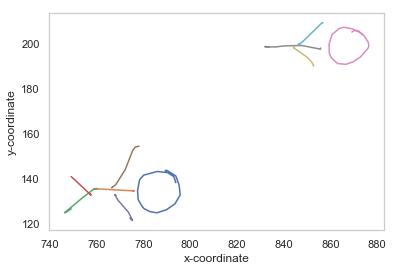

In [19]:
for i in range(10):
    plot_task(drawings[0][i])

In [28]:
str_list="""478.75 897.5 1219149371.986 52,'.25'.125'.013'58,"1.25"-4.125".014"-52, 1-3.625-.001-2,-1.625 4.625-.012-4,-.75 1.125-.001 0,-.875 1.25 0-2,-.625 .75 .001 0,-3.25 3.375 .012-6, 2-2.625 .001 8, 1.5-1.625-.014 4,-1.25-2.5 .027 2, 1.75 3.5-.013-4,-2.625 6.875 .013-2, 2.75-4-.027 0, .75 1.375 .027 0,-1.25-8.5 0 0,-.5 1.25-.026 0,-.125 .75-.001 0,-.125 .875 0 0, 0 .875 .001 0, .375 .625-.001 0, .25 1 0-2, .625 .75 .001 2, .875-.375-.001 0, .75-.875 0 0, 0-1 .001 2, .25-.875-.001-2,-.125-1.125 0 2,-.25-.75 .001-2,-1 1.125-.001 0,-.75 .5 0 0,-.75 .5 .001 0,-.375 1.25-.001-2,-2.125 3.625 .014 0, 2.375 1.25-.001 0, 2-4.125-.012 4, .75-1.25 .012 0,-.375-1.25-.012 0, .25-.75-.001-2,-.625-.375 0 0,-.5-.25 .001 0,-.5 1-.001 0,-.625 .375 0 0,-.25 1.125 .001-2,-1.125 1.5-.001 0, .125 .875 0-2, .5 .625 .001-4, .5 .25-.001 0, 1.125-1.25 .014 24, 1.625-3.375-.001-10,-.125-2.25 .001-4,-.75 .125 0-2,-.875 2.5-.014 0,-.25 .875 0-2,-1 .875 .001 0,-1 1.25-.001-4, .75 .625 0-12, .625 .25 .001-76, .625-1.125-.001 94, 1-1.75 0 108, .625-1.75 .014-98,-.125 0-.014-10,-.375-1.625 .014 2,-1 2.625-.014-2,-.25 .625 .001 0,-1.625 1.25-.001-2,-.875 1 0 0,-2.625 3.625 .014-12, 3.875-2.25-.014 10, 1 .25 .001 8, .875-1.5-.001 8, .75-1.375 0-10, 1.625-2 .014 2, 1.125-4.125 0-4,-1.375-1.5-.001 2,-1.5 3.875-.012-2,-1 1-.001 0,-.375 1.125 0 0,-1 1.25 .001-2,-1 1-.001 0,-2.75 2.75 .027-2, 6.25-5.875 .04 10,-.5 2.875-.053-8, 1.25 .75-.001 2, .75-2.25 .001 2,-.75-1.375-.014-2, .875-3.375 .014 2,-2.375 3.5-.014-2,-.5 .875 .001 0,-1.125 1.25-.001-2,-1.25 1.5 0 2,-.125 1.25 .001-4, 0 1.75-.001-12, 0 1.5 0-64, .375-.375 .014 174, 3.125-6-.014-88, 1.5-2.875 .014-4, 1-5.875 0 0,-1.375 .375-.001-4,-1.25 4.75-.012-4""".split(",")

In [41]:
x_y=np.asarray([np.asarray(str_list[i].replace("-"," -").split(),dtype=float) for i,_ in enumerate(str_list) if i%3==0])

In [59]:
np_array=np.zeros((len(str_list)//3+1,4),dtype=float)

In [60]:
last_values=np.zeros(4,dtype=float)
for i,_ in enumerate(str_list):
    if i%3==0:
        cur_val=np.asarray(str_list[i].replace("-"," -").split(),dtype=float)
        last_values+=cur_val
        np_array[i//3]=last_values
        


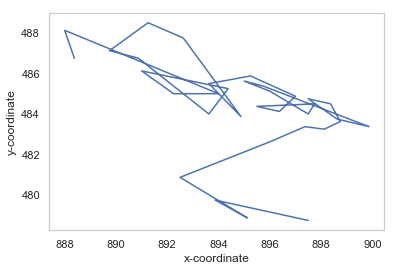

In [65]:
plot_task(np_array[:,:2])

In [57]:
 4.79750000e+02 -8.75000000e-01  

478.875

In [1]:
from smartmanuscript.inkml import TraceParser

parse = TraceParser()


target=parse("""478.75 897.5 1219149371.986 52,'.25'.125'.013'58,"1.25"-4.125".014"-52, 1-3.625-.001-2,-1.625 4.625-.012-4,-.75 1.125-.001 0,-.875 1.25 0-2,-.625 .75 .001 0,-3.25 3.375 .012-6, 2-2.625 .001 8, 1.5-1.625-.014 4,-1.25-2.5 .027 2, 1.75 3.5-.013-4,-2.625 6.875 .013-2, 2.75-4-.027 0, .75 1.375 .027 0,-1.25-8.5 0 0,-.5 1.25-.026 0,-.125 .75-.001 0,-.125 .875 0 0, 0 .875 .001 0, .375 .625-.001 0, .25 1 0-2, .625 .75 .001 2, .875-.375-.001 0, .75-.875 0 0, 0-1 .001 2, .25-.875-.001-2,-.125-1.125 0 2,-.25-.75 .001-2,-1 1.125-.001 0,-.75 .5 0 0,-.75 .5 .001 0,-.375 1.25-.001-2,-2.125 3.625 .014 0, 2.375 1.25-.001 0, 2-4.125-.012 4, .75-1.25 .012 0,-.375-1.25-.012 0, .25-.75-.001-2,-.625-.375 0 0,-.5-.25 .001 0,-.5 1-.001 0,-.625 .375 0 0,-.25 1.125 .001-2,-1.125 1.5-.001 0, .125 .875 0-2, .5 .625 .001-4, .5 .25-.001 0, 1.125-1.25 .014 24, 1.625-3.375-.001-10,-.125-2.25 .001-4,-.75 .125 0-2,-.875 2.5-.014 0,-.25 .875 0-2,-1 .875 .001 0,-1 1.25-.001-4, .75 .625 0-12, .625 .25 .001-76, .625-1.125-.001 94, 1-1.75 0 108, .625-1.75 .014-98,-.125 0-.014-10,-.375-1.625 .014 2,-1 2.625-.014-2,-.25 .625 .001 0,-1.625 1.25-.001-2,-.875 1 0 0,-2.625 3.625 .014-12, 3.875-2.25-.014 10, 1 .25 .001 8, .875-1.5-.001 8, .75-1.375 0-10, 1.625-2 .014 2, 1.125-4.125 0-4,-1.375-1.5-.001 2,-1.5 3.875-.012-2,-1 1-.001 0,-.375 1.125 0 0,-1 1.25 .001-2,-1 1-.001 0,-2.75 2.75 .027-2, 6.25-5.875 .04 10,-.5 2.875-.053-8, 1.25 .75-.001 2, .75-2.25 .001 2,-.75-1.375-.014-2, .875-3.375 .014 2,-2.375 3.5-.014-2,-.5 .875 .001 0,-1.125 1.25-.001-2,-1.25 1.5 0 2,-.125 1.25 .001-4, 0 1.75-.001-12, 0 1.5 0-64, .375-.375 .014 174, 3.125-6-.014-88, 1.5-2.875 .014-4, 1-5.875 0 0,-1.375 .375-.001-4,-1.25 4.75-.012-4""")

In [2]:
target.shape

(101, 4)

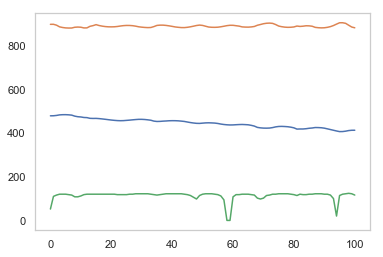

In [8]:
plt.plot(target[:,:2])
plt.plot(target[:,-1])

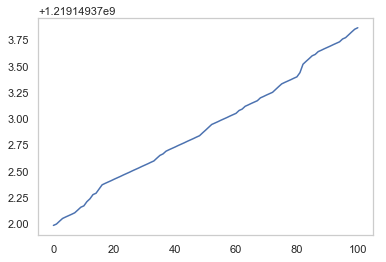

In [9]:
plt.plot(target[:,2])

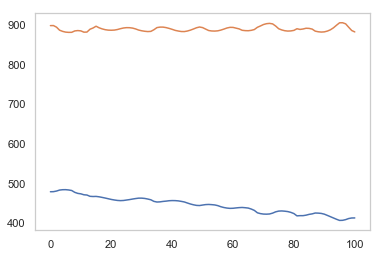

In [7]:
plt.plot(target[:,:2])

In [87]:
for i in range(10):
    number = r"([+-]\s*)?([0-9]*[.])?[0-9]+"
    value = r"(\"|'|!)?\s*{}".format(number)
    rule = r"(?P<x>{0})(?P<y>{0}).*".format(value)
    match = re.match(rule, str_list[i])

    match.group('x')
    print("\ninput str, x match :")
    print(str_list[i],"\n",match.group('y'))


input str, x match :
478.75 897.5 1219149371.986 52 
  897.5

input str, x match :
'.25'.125'.013'58 
 '.125

input str, x match :
"1.25"-4.125".014"-52 
 "-4.125

input str, x match :
 1-3.625-.001-2 
 -3.625

input str, x match :
-1.625 4.625-.012-4 
  4.625

input str, x match :
-.75 1.125-.001 0 
  1.125

input str, x match :
-.875 1.25 0-2 
  1.25

input str, x match :
-.625 .75 .001 0 
  .75

input str, x match :
-3.25 3.375 .012-6 
  3.375

input str, x match :
 2-2.625 .001 8 
 -2.625


In [77]:
import re

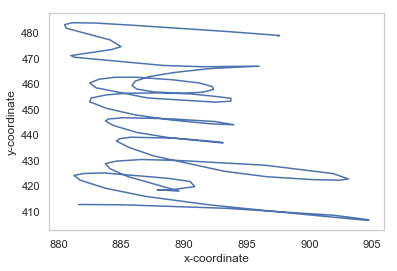

In [73]:
plot_task(target)

In [75]:
str_list

['478.75 897.5 1219149371.986 52',
 "'.25'.125'.013'58",
 '"1.25"-4.125".014"-52',
 ' 1-3.625-.001-2',
 '-1.625 4.625-.012-4',
 '-.75 1.125-.001 0',
 '-.875 1.25 0-2',
 '-.625 .75 .001 0',
 '-3.25 3.375 .012-6',
 ' 2-2.625 .001 8',
 ' 1.5-1.625-.014 4',
 '-1.25-2.5 .027 2',
 ' 1.75 3.5-.013-4',
 '-2.625 6.875 .013-2',
 ' 2.75-4-.027 0',
 ' .75 1.375 .027 0',
 '-1.25-8.5 0 0',
 '-.5 1.25-.026 0',
 '-.125 .75-.001 0',
 '-.125 .875 0 0',
 ' 0 .875 .001 0',
 ' .375 .625-.001 0',
 ' .25 1 0-2',
 ' .625 .75 .001 2',
 ' .875-.375-.001 0',
 ' .75-.875 0 0',
 ' 0-1 .001 2',
 ' .25-.875-.001-2',
 '-.125-1.125 0 2',
 '-.25-.75 .001-2',
 '-1 1.125-.001 0',
 '-.75 .5 0 0',
 '-.75 .5 .001 0',
 '-.375 1.25-.001-2',
 '-2.125 3.625 .014 0',
 ' 2.375 1.25-.001 0',
 ' 2-4.125-.012 4',
 ' .75-1.25 .012 0',
 '-.375-1.25-.012 0',
 ' .25-.75-.001-2',
 '-.625-.375 0 0',
 '-.5-.25 .001 0',
 '-.5 1-.001 0',
 '-.625 .375 0 0',
 '-.25 1.125 .001-2',
 '-1.125 1.5-.001 0',
 ' .125 .875 0-2',
 ' .5 .625 .001-4',
 ' 

In [74]:
target

array([[478.75 , 897.5  ],
       [479.   , 897.625],
       [480.5  , 893.625],
       [483.   , 886.   ],
       [483.875, 883.   ],
       [484.   , 881.125],
       [483.25 , 880.5  ],
       [481.875, 880.625],
       [477.25 , 884.125],
       [474.625, 885.   ],
       [473.5  , 884.25 ],
       [471.125, 881.   ],
       [470.5  , 881.25 ],
       [467.25 , 888.375],
       [466.75 , 891.5  ],
       [467.   , 896.   ],
       [466.   , 892.   ],
       [464.5  , 889.25 ],
       [462.875, 887.25 ],
       [461.125, 886.125],
       [459.375, 885.875],
       [458.   , 886.25 ],
       [456.875, 887.625],
       [456.375, 889.75 ],
       [456.75 , 891.5  ],
       [457.875, 892.375],
       [459.   , 892.25 ],
       [460.375, 891.25 ],
       [461.625, 889.125],
       [462.625, 886.25 ],
       [462.625, 884.5  ],
       [461.875, 883.25 ],
       [460.375, 882.5  ],
       [458.5  , 883.   ],
       [454.5  , 887.125],
       [452.875, 892.5  ],
       [453.25 , 893.75 ],
 

In [66]:
print(np_array)

[[4.78750000e+02 8.97500000e+02 1.21914937e+09 5.20000000e+01]
 [4.79750000e+02 8.93875000e+02 1.21914937e+09 5.00000000e+01]
 [4.78875000e+02 8.95125000e+02 1.21914937e+09 4.80000000e+01]
 [4.80875000e+02 8.92500000e+02 1.21914937e+09 5.60000000e+01]
 [4.82625000e+02 8.96000000e+02 1.21914937e+09 5.20000000e+01]
 [4.83375000e+02 8.97375000e+02 1.21914937e+09 5.20000000e+01]
 [4.83250000e+02 8.98125000e+02 1.21914937e+09 5.20000000e+01]
 [4.83625000e+02 8.98750000e+02 1.21914937e+09 5.20000000e+01]
 [4.84500000e+02 8.98375000e+02 1.21914937e+09 5.20000000e+01]
 [4.84750000e+02 8.97500000e+02 1.21914937e+09 5.00000000e+01]
 [4.83750000e+02 8.98625000e+02 1.21914937e+09 5.00000000e+01]
 [4.83375000e+02 8.99875000e+02 1.21914937e+09 4.80000000e+01]
 [4.85375000e+02 8.95750000e+02 1.21914937e+09 5.20000000e+01]
 [4.85625000e+02 8.95000000e+02 1.21914937e+09 5.00000000e+01]
 [4.85125000e+02 8.96000000e+02 1.21914937e+09 5.00000000e+01]
 [4.84000000e+02 8.97500000e+02 1.21914937e+09 5.000000

In [54]:
print(x_y)

[[ 4.78750000e+02  8.97500000e+02  1.21914937e+09  5.20000000e+01]
 [ 1.00000000e+00 -3.62500000e+00 -1.00000000e-03 -2.00000000e+00]
 [-8.75000000e-01  1.25000000e+00  0.00000000e+00 -2.00000000e+00]
 [ 2.00000000e+00 -2.62500000e+00  1.00000000e-03  8.00000000e+00]
 [ 1.75000000e+00  3.50000000e+00 -1.30000000e-02 -4.00000000e+00]
 [ 7.50000000e-01  1.37500000e+00  2.70000000e-02  0.00000000e+00]
 [-1.25000000e-01  7.50000000e-01 -1.00000000e-03  0.00000000e+00]
 [ 3.75000000e-01  6.25000000e-01 -1.00000000e-03  0.00000000e+00]
 [ 8.75000000e-01 -3.75000000e-01 -1.00000000e-03  0.00000000e+00]
 [ 2.50000000e-01 -8.75000000e-01 -1.00000000e-03 -2.00000000e+00]
 [-1.00000000e+00  1.12500000e+00 -1.00000000e-03  0.00000000e+00]
 [-3.75000000e-01  1.25000000e+00 -1.00000000e-03 -2.00000000e+00]
 [ 2.00000000e+00 -4.12500000e+00 -1.20000000e-02  4.00000000e+00]
 [ 2.50000000e-01 -7.50000000e-01 -1.00000000e-03 -2.00000000e+00]
 [-5.00000000e-01  1.00000000e+00 -1.00000000e-03  0.00000000e

In [43]:
x_y[1:]+x_y[0]

array([[ 4.79750000e+02,  8.93875000e+02,  1.21914937e+09,
         5.00000000e+01],
       [ 4.77875000e+02,  8.98750000e+02,  1.21914937e+09,
         5.00000000e+01],
       [ 4.80750000e+02,  8.94875000e+02,  1.21914937e+09,
         6.00000000e+01],
       [ 4.80500000e+02,  9.01000000e+02,  1.21914937e+09,
         4.80000000e+01],
       [ 4.79500000e+02,  8.98875000e+02,  1.21914937e+09,
         5.20000000e+01],
       [ 4.78625000e+02,  8.98250000e+02,  1.21914937e+09,
         5.20000000e+01],
       [ 4.79125000e+02,  8.98125000e+02,  1.21914937e+09,
         5.20000000e+01],
       [ 4.79625000e+02,  8.97125000e+02,  1.21914937e+09,
         5.20000000e+01],
       [ 4.79000000e+02,  8.96625000e+02,  1.21914937e+09,
         5.00000000e+01],
       [ 4.77750000e+02,  8.98625000e+02,  1.21914937e+09,
         5.20000000e+01],
       [ 4.78375000e+02,  8.98750000e+02,  1.21914937e+09,
         5.00000000e+01],
       [ 4.80750000e+02,  8.93375000e+02,  1.21914937e+09,
      

In [37]:
str_x_y

['478.75 897.5 1219149371.986 52',
 ' 1-3.625-.001-2',
 '-.875 1.25 0-2',
 ' 2-2.625 .001 8',
 ' 1.75 3.5-.013-4',
 ' .75 1.375 .027 0',
 '-.125 .75-.001 0',
 ' .375 .625-.001 0',
 ' .875-.375-.001 0',
 ' .25-.875-.001-2',
 '-1 1.125-.001 0',
 '-.375 1.25-.001-2',
 ' 2-4.125-.012 4',
 ' .25-.75-.001-2',
 '-.5 1-.001 0',
 '-1.125 1.5-.001 0',
 ' .5 .25-.001 0',
 '-.125-2.25 .001-4',
 '-.25 .875 0-2',
 ' .75 .625 0-12',
 ' 1-1.75 0 108',
 '-.375-1.625 .014 2',
 '-1.625 1.25-.001-2',
 ' 3.875-2.25-.014 10',
 ' .75-1.375 0-10',
 '-1.375-1.5-.001 2',
 '-.375 1.125 0 0',
 '-2.75 2.75 .027-2',
 ' 1.25 .75-.001 2',
 ' .875-3.375 .014 2',
 '-1.125 1.25-.001-2',
 ' 0 1.75-.001-12',
 ' 3.125-6-.014-88',
 '-1.375 .375-.001-4']

In [34]:
str_list

['478.75 897.5 1219149371.986 52',
 "'.25'.125'.013'58",
 '"1.25"-4.125".014"-52',
 ' 1-3.625-.001-2',
 '-1.625 4.625-.012-4',
 '-.75 1.125-.001 0',
 '-.875 1.25 0-2',
 '-.625 .75 .001 0',
 '-3.25 3.375 .012-6',
 ' 2-2.625 .001 8',
 ' 1.5-1.625-.014 4',
 '-1.25-2.5 .027 2',
 ' 1.75 3.5-.013-4',
 '-2.625 6.875 .013-2',
 ' 2.75-4-.027 0',
 ' .75 1.375 .027 0',
 '-1.25-8.5 0 0',
 '-.5 1.25-.026 0',
 '-.125 .75-.001 0',
 '-.125 .875 0 0',
 ' 0 .875 .001 0',
 ' .375 .625-.001 0',
 ' .25 1 0-2',
 ' .625 .75 .001 2',
 ' .875-.375-.001 0',
 ' .75-.875 0 0',
 ' 0-1 .001 2',
 ' .25-.875-.001-2',
 '-.125-1.125 0 2',
 '-.25-.75 .001-2',
 '-1 1.125-.001 0',
 '-.75 .5 0 0',
 '-.75 .5 .001 0',
 '-.375 1.25-.001-2',
 '-2.125 3.625 .014 0',
 ' 2.375 1.25-.001 0',
 ' 2-4.125-.012 4',
 ' .75-1.25 .012 0',
 '-.375-1.25-.012 0',
 ' .25-.75-.001-2',
 '-.625-.375 0 0',
 '-.5-.25 .001 0',
 '-.5 1-.001 0',
 '-.625 .375 0 0',
 '-.25 1.125 .001-2',
 '-1.125 1.5-.001 0',
 ' .125 .875 0-2',
 ' .5 .625 .001-4',
 ' 

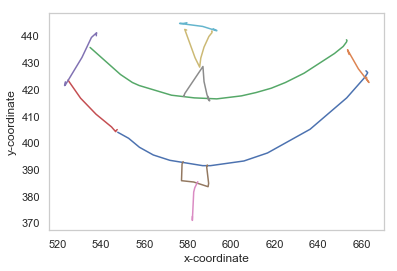

In [17]:
for i in range(10):
    plot_task(drawings[1][i])

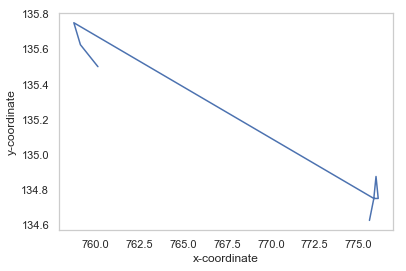

In [14]:
plot_task(drawings[0][1])

In [10]:
type(drawings[0][0])

numpy.ndarray

In [10]:
len(words[0][1
            ]
   )

2

In [4]:
if False:    
    if False:        
        words, lines = _import_set(iamondo_path, "{}.set".format(set_number), max_files=None)

        data=np.asarray([stroke for word in words for stroke in  word[1]])
    else:
        print("loading raw data")
        data=np.load(join("data","0_1.set.npy"))
        print("raw data shape",data.shape)
    print("scaling and padding data at",max_len)
    tmp=[]
    for stroke in data:
        stroke=scale(stroke,axis=0)
        if len(stroke) > max_len:
            stroke=stroke[:max_len]
        else:
            stroke=np.concatenate((stroke,np.zeros(shape=(max_len-len(stroke),stroke.shape[1]))))#zero-padding
        tmp.append(stroke)
    data=np.asarray(tmp)
    print("data.shape",data.shape)
    np.save("data/padded_0_1.set.npy",data)
else:
    print("loading scaled and padded data")
    train_set=np.load(join("data","padded_0_1.set.npy"))
    test_set=np.load(join("data","padded_3.set.npy"))
    #reverse x and y column to match PaHaW
    train_set=train_set[:,:,::-1]
    test_set=test_set[:,:,::-1]
    print("train_set.shape",train_set.shape)
    print("test_set.shape",test_set.shape)

loading scaled and padded data
train_set.shape (114564, 288, 2)
test_set.shape (57562, 288, 2)


#  Model

https://pytorch.org/docs/stable/nn.html#convtranspose1d

In [6]:
import torch

class CNNAutoencoder(torch.nn.Module):
    def __init__(self,input_size,hidden_size,conv_kernel,pool_kernel ,padding,
                 stride=1,dilation=1, dropout=0.0):
        super(CNNAutoencoder, self).__init__()
        self.num_layers=len(hidden_size) 
        
        layers=[]
        for i, (h,c,p,pad) in enumerate(list(zip(hidden_size,conv_kernel,pool_kernel,padding))):
            s = input_size if i ==0 else hidden_size[i-1]
            layers+=[
                torch.nn.Conv1d(s,h,c,stride=p,padding=pad,dilation=1),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout)
            ]
        self.encoder=torch.nn.Sequential(*layers)
        
        layers=[]
        for i, (h,c,p,pad) in enumerate(list(zip(hidden_size,conv_kernel,pool_kernel,padding))[::-1]):
            if i ==self.num_layers-1:                
                s= input_size
                layers+=[
                    torch.nn.ConvTranspose1d(h,s,c,stride=p,padding=pad,dilation=1)
                ]
            else :
                s = hidden_size[::-1][i+1]      
                layers+=[
                    torch.nn.ConvTranspose1d(h,s,c,stride=p,padding=pad,dilation=1),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(dropout)
                ]        
        self.decoder=torch.nn.Sequential(*layers)
        
    def forward(self,subject):
        code=self.encoder(subject)
        decode=self.decoder(code)        
        return decode#self.sigmoid(d_c1)


# Training def

In [7]:
def step(input, target, model, optimizer, loss_fn, batch_size,validation = False, device="cuda"):
    if not validation:
        # Zero gradients
        optimizer.zero_grad()

    # Set device options
    input=input.to(device)
    target=target.to(device)
    #forward pass
    output=model(input)

    # Compute loss
    loss = loss_fn(output, target)
    if not validation:
        # Perform backpropagation
        loss.backward()
        # Adjust model weights
        optimizer.step()
    return loss.item(), output.squeeze().cpu().detach().numpy()

#  Hyperparameters

In [114]:
288/16

18.0

In [115]:
18/8

2.25

In [14]:
dropout=0.0
hidden_size=[16,32,64]  
conv_kernel= [8,4,3]
pool_kernel=[8,4,3]
assert (max_len/np.prod(pool_kernel))%1==0
dilation= 'redef as 1'#[1,1]
stride='redef as kernel_size'
output_size="foo"
padding=[0,0,0]
"""for d,k in list(zip(dilation,conv_kernel)):
    padding.append((k-1)//2)#d*(k-1)//2)"""
input_size=2
batch_size=64
loss_fn=torch.nn.MSELoss()

learning_rate=1e-3
verbose=False
model_type="CNNAutoencoder"

model_name=str((model_type,learning_rate,hidden_size, dropout, conv_kernel,pool_kernel,dilation))

In [15]:
torch.manual_seed(1)
model=CNNAutoencoder(input_size,hidden_size,conv_kernel,pool_kernel ,padding,stride,dilation, dropout)

model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
print(count_params(model))
print(model)
start = time()
train_loss,test_loss=[],[]
for epoch in range(10):
    np.random.seed(1)
    np.random.shuffle(train_set)#shuffle train_set to facilitate SGD
    
    #training
    model.train()
    batch_loss=0
    for batch_i in range(0,len(train_set),batch_size):
        batch=torch.Tensor(train_set[batch_i:batch_i+batch_size].copy()).transpose(1,2)
        loss,output=step(batch, batch, model, optimizer, loss_fn, batch_size,False,device)
        batch_loss+=loss
    train_loss.append(batch_loss/(len(train_set)//batch_size))
    
    #testing
    model.eval()
    batch_loss=0
    for batch_i in range(0,len(test_set),batch_size):
        batch=torch.Tensor(test_set[batch_i:batch_i+batch_size].copy()).transpose(1,2)
        loss,output=step(batch, batch, model, optimizer, loss_fn, batch_size,True,device)
        batch_loss+=loss
    test_loss.append(batch_loss/(len(test_set)//batch_size))
    if verbose:
        print(epoch,train_loss[-1],test_loss[-1])

print("Done. Spent",timeSince(start))

(17058, 17058)
CNNAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(2, 16, kernel_size=(8,), stride=(8,))
    (1): ReLU()
    (2): Dropout(p=0.0)
    (3): Conv1d(16, 32, kernel_size=(4,), stride=(4,))
    (4): ReLU()
    (5): Dropout(p=0.0)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(3,))
    (7): ReLU()
    (8): Dropout(p=0.0)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(3,))
    (1): ReLU()
    (2): Dropout(p=0.0)
    (3): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(4,))
    (4): ReLU()
    (5): Dropout(p=0.0)
    (6): ConvTranspose1d(16, 2, kernel_size=(8,), stride=(8,))
  )
)
Done. Spent 1m 31s


In [128]:
model.decoder[0]

ConvTranspose1d(64, 32, kernel_size=(6,), stride=(3,), padding=(2,))

In [ ]:
model.encoder(target).shape

In [92]:
directory = join("weights", model_name)
if not exists(directory):
    makedirs(directory)
torch.save({
    'epoch': epoch,
    'model': model.state_dict(),
    'opt': optimizer.state_dict(),
    'loss': test_loss[-1]
}, join(directory, '{}_checkpoint.tar'.format(epoch)))

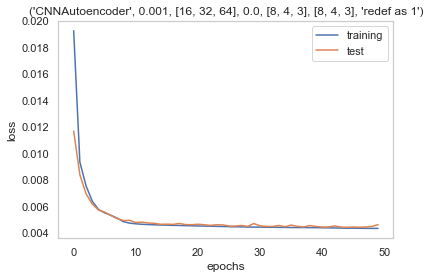

In [83]:
plot(0,train_loss,None,test_loss)

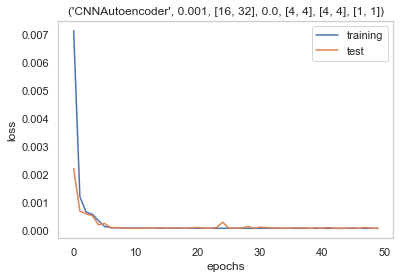

In [42]:
plot(0,train_loss,None,test_loss)

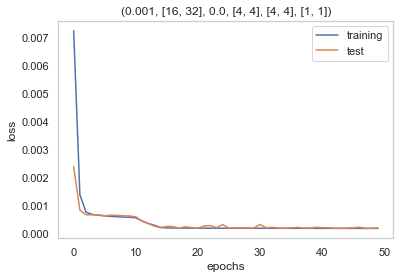

In [116]:
plot(0,train_loss,None,test_loss)

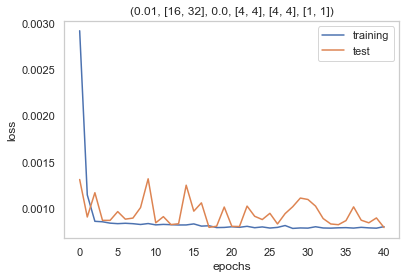

In [106]:
plot(0,train_loss,None,test_loss)

In [52]:
test_set[0:0+batch_size,:,::-1].shape

(64, 288, 2)

In [22]:
batch=torch.Tensor(test_set[0:0+batch_size,:,:].copy()).transpose(1,2)
loss,output=step(batch, batch, model, optimizer, loss_fn, batch_size,True,device)

In [20]:
trim_to=50

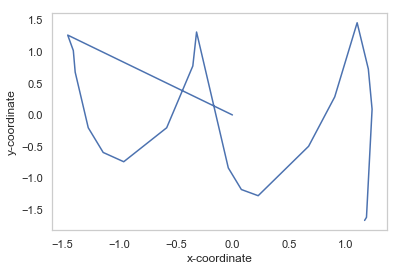

In [26]:
plot_task(test_set[30,:trim_to])

In [76]:
c1=model.encoder[0](batch.to(device))
r1=model.encoder[1](c1)
c2=model.encoder[3](r1)
r2=model.encoder[4](c2)
c3=model.encoder[6](r2)
r3=model.encoder[7](c3)
dc1=model.decoder[0](r3)
dr1=model.decoder[1](dc1)
dc2=model.decoder[3](dr1)
dr2=model.decoder[4](dc2)
dc3=model.decoder[6](dr2)

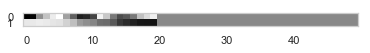

In [79]:
plt.imshow(test_set[30,:trim_to].T,cmap="gray")

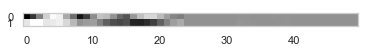

In [91]:
plt.imshow(dc3.detach().cpu().numpy()[30,:,:trim_to],cmap="gray")

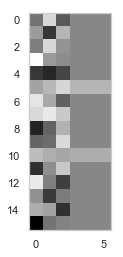

In [82]:
plt.imshow(c1.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

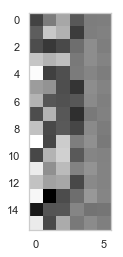

In [90]:
plt.imshow(dc2.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

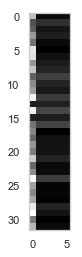

In [86]:
plt.imshow(c2.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

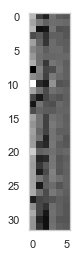

In [89]:
plt.imshow(dc1.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

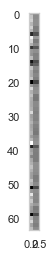

In [88]:
plt.imshow(c3.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

In [36]:
model

CNNAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(2, 16, kernel_size=(8,), stride=(8,))
    (1): ReLU()
    (2): Dropout(p=0.0)
    (3): Conv1d(16, 32, kernel_size=(4,), stride=(4,))
    (4): ReLU()
    (5): Dropout(p=0.0)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(3,))
    (7): ReLU()
    (8): Dropout(p=0.0)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(3,))
    (1): ReLU()
    (2): Dropout(p=0.0)
    (3): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(4,))
    (4): ReLU()
    (5): Dropout(p=0.0)
    (6): ConvTranspose1d(16, 2, kernel_size=(8,), stride=(8,))
  )
)

In [41]:
c1=model.encoder(batch.to(device))

In [31]:
c1.shape

torch.Size([64, 16, 36])

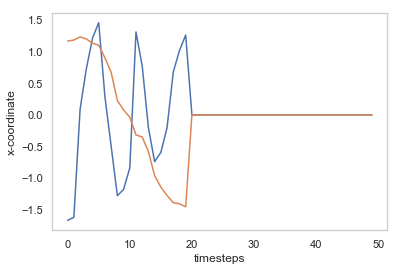

In [44]:
plot_measures(test_set[30,:trim_to],False,(6,4))

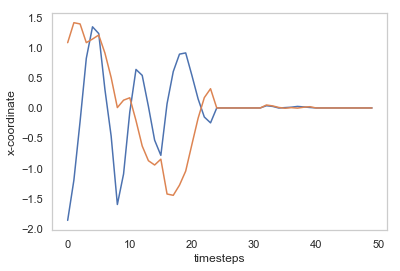

In [28]:
plot_measures(output[30].T[:trim_to],False,(6,4))

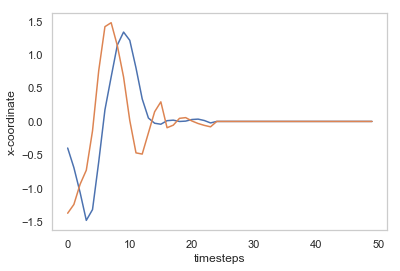

In [89]:
plot_measures(output[i-1].T[:trim_to],False,(6,4))

In [45]:
c1=model.conv1(batch)
r1=model.relu1(c1)

if model.num_layers > 1:
    drop1=model.drop1(r1)
    c2=model.conv2(drop1)
    r2=model.relu2(c2)
    d_drop2=model.d_drop2(r2)
    d_c2=model.d_conv2(d_drop2)
    d_r2=model.d_relu2(d_c2)
    d_drop1=model.d_drop1(d_r2)
else:
    d_drop1=model.d_drop1(r1)

d_c1=model.d_conv1(d_drop1)

AttributeError: 'CNNAutoencoder' object has no attribute 'conv1'

In [96]:
c1.shape

torch.Size([1, 16, 72])

In [99]:
c2.shape

torch.Size([1, 32, 18])

In [97]:
d_c2.shape

torch.Size([1, 16, 72])

In [98]:
d_c1.shape

torch.Size([1, 2, 288])

In [ ]:
p1.shape

In [ ]:
289/17

In [ ]:
model

In [ ]:
plot_task(train_set[0],measure2index)

In [ ]:
289/72

# keep for ref

In [150]:
import torch

class CNNAutoencoder(torch.nn.Module):
    def __init__(self,input_size,hidden_size,conv_kernel,pool_kernel ,padding,
                 stride=1,dilation=1, dropout=0.0):
        super(CNNAutoencoder, self).__init__()

        self.num_layers=len(hidden_size) 
                
        #encoder
        self.conv1=torch.nn.Conv1d(input_size,hidden_size[0],conv_kernel[0],stride=pool_kernel[0],padding=padding[0],dilation=dilation[0])
        self.relu1=torch.nn.ReLU()
        if self.num_layers > 1:
            self.drop1=torch.nn.Dropout(dropout)
            self.conv2=torch.nn.Conv1d(hidden_size[0],hidden_size[1],conv_kernel[1],stride=pool_kernel[1],padding=padding[1],dilation=dilation[1])
            self.relu2=torch.nn.ReLU()
        #self.drop2=torch.nn.Dropout(dropout)
        
        #decoder        
        if self.num_layers > 1:
            self.d_drop2=torch.nn.Dropout(dropout)
            self.d_conv2=torch.nn.ConvTranspose1d(hidden_size[1],hidden_size[0],conv_kernel[1],stride=pool_kernel[1],
                                         padding=padding[1],dilation=dilation[1])
            self.d_relu2=torch.nn.ReLU()
        self.d_drop1=torch.nn.Dropout(dropout)
        self.d_conv1=torch.nn.ConvTranspose1d(hidden_size[0],input_size,conv_kernel[0],stride=pool_kernel[0],
                                     padding=padding[0],dilation=dilation[0])
        #self.sigmoid=torch.nn.Sigmoid()
        
    def forward(self,subject):
        c1=self.conv1(subject)
        r1=self.relu1(c1)

        if self.num_layers > 1:
            drop1=self.drop1(r1)
            c2=self.conv2(drop1)
            r2=self.relu2(c2)
            d_drop2=self.d_drop2(r2)
            d_c2=self.d_conv2(d_drop2)
            d_r2=self.d_relu2(d_c2)
            d_drop1=self.d_drop1(d_r2)
        else:
            d_drop1=self.d_drop1(r1)
            
        d_c1=self.d_conv1(d_drop1)
        
        return d_c1#self.sigmoid(d_c1)


13.92721099123634

In [ ]:
import torch

class CNNAutoencoder(torch.nn.Module):
    def __init__(self,input_size,hidden_size,conv_kernel,pool_kernel ,padding,
                 stride=1,dilation=1, dropout=0.0):
        super(CNNAutoencoder, self).__init__()

        self.num_layers=len(hidden_size) 
        
        #encoder
        self.conv1=torch.nn.utils.weight_norm(
            torch.nn.Conv1d(input_size,hidden_size[0],conv_kernel[0],stride=1,padding=padding[0],dilation=dilation[0]))
        self.relu1=torch.nn.ReLU()
        self.pool1=torch.nn.MaxPool1d(pool_kernel[0],pool_kernel[0],padding=0,dilation=1)
        if self.num_layers > 1:
            self.drop1=torch.nn.Dropout(dropout)
            self.conv2=torch.nn.utils.weight_norm(
                torch.nn.Conv1d(hidden_size[0],hidden_size[1],conv_kernel[1],stride=1,padding=padding[1],dilation=dilation[1]))
            self.relu2=torch.nn.ReLU()
            self.pool2=torch.nn.MaxPool1d(pool_kernel[1],pool_kernel[1],padding=0,dilation=1)
        self.drop2=torch.nn.Dropout(dropout)
        
        #decoder        
        if self.num_layers > 1:
            self.d_drop2=torch.nn.Dropout(dropout)
            self.d_conv2=torch.nn.utils.weight_norm(
                torch.nn.ConvTranspose1d(hidden_size[1],hidden_size[0],conv_kernel[1],stride=pool_kernel[1],
                                         padding=padding[1],dilation=dilation[1],output_padding=pool_kernel[1]-1))
            self.d_relu2=torch.nn.ReLU()
        self.d_drop1=torch.nn.Dropout(dropout)
        self.d_conv1=torch.nn.utils.weight_norm(
            torch.nn.ConvTranspose1d(hidden_size[0],input_size,conv_kernel[0],stride=pool_kernel[0],
                                     padding=padding[0],dilation=dilation[0],output_padding=pool_kernel[0]-1))
        #self.sigmoid=torch.nn.Sigmoid()
        
    def forward(self,subject):
        c1=self.conv1(subject)
        r1=self.relu1(c1)
        p1=self.pool1(r1)

        if self.num_layers > 1:
            drop1=self.drop1(p1)
            c2=self.conv2(drop1)
            r2=self.relu2(c2)
            p2=self.pool2(r2)
            drop2=self.drop2(p2)
            d_c2=self.d_conv2(drop2)
            d_r2=self.d_relu2(d_c2)
            d_drop2=self.d_drop2(d_r2)
        else:
            d_drop2=self.drop2(p1)
            
        d_c1=self.d_conv1(d_drop2)
        
        return d_c1#self.sigmoid(d_c1)


In [ ]:
c1=model.conv1(subject)
r1=model.relu1(c1)
p1=model.pool1(r1)

if model.num_layers > 1:
    drop1=model.drop1(p1)
    c2=model.conv2(drop1)
    r2=model.relu2(c2)
    p2=model.pool2(r2)
    drop2=model.drop2(p2)
    d_c2=model.d_conv2(drop2)
    d_r2=model.d_relu2(d_c2)
    d_drop2=model.d_drop2(d_r2)
else:
    d_drop2=model.drop2(p1)

d_c1=model.d_conv1(d_drop2)